# Word and Constituent Boundary in Hierarchical Multiscale LSTM

In [1]:
import matplotlib.pyplot as plt
import numpy
import glob
import pickle


In [2]:
def load_files():
    results = []
    for f in glob.glob("eval_*.pkl"):
        results.append(pickle.load(open(f, 'rb')))
    results = sorted(results, key=lambda k: k['bpc'])
    return results

In [3]:
bpc_score_rst = load_files()

### 0. Baseline: Random binary boundary indicators as baseline

In [4]:
import random
import numpy as np
from evaluate import EvaluateBoundary

rand_file = 'rand.tmp'

def rand_bound(file_truth):
    # generate random binary indicators
    labelize = lambda bounds: np.array(list(bounds.strip()))
    with open(file_truth, 'r') as f:
        truth = labelize(f.read())
    _rand = [str(random.randint(0,1)) for i in range(len(truth))]
    with open(rand_file, 'w') as f:
        f.write(''.join(_rand))
    
    # evaluate random binary indicators
    _eval = EvaluateBoundary('corpora/boundaries.txt', rand_file)
    return _eval.evaluate(read_loss=False)

In [5]:
rand_score = rand_bound('corpora/boundaries.txt')[rand_file]
rand_precision = rand_score[0][0]
rand_recall = rand_score[1][0]
rand_f1 = rand_score[2][0]

### 1. BPC vs. F1-score for layer-wise boundary indicators predicted by HM-LSTM

In [6]:
def bpc_vs_scores(bpc_score_rst, num_layers=3):
    bpc = []
    precision_all = [[] for i in range(num_layers)]
    recall_all = [[] for i in range(num_layers)]
    f1_all = [[] for i in range(num_layers)]
    for v in bpc_score_rst:
        bpc.append(v['bpc'])
        for l in range(num_layers):
            layer = 'layer_{}_bound.txt'.format(l)
            precision_all[l].append(v[layer][0][0])
            recall_all[l].append(v[layer][1][0])
            f1_all[l].append(v[layer][2][0])
    return bpc, precision_all, recall_all, f1_all

In [7]:
bpc, _, _, f1 = bpc_vs_scores(bpc_score_rst)

In [8]:
def plot_bpc_f1(bpc, f1, num_layers=3):
    layer_name = ['word', 'phrase', 'sentence']
    for l in range(num_layers):
        lw = 3 if l is 1 else 1
        plt.plot(bpc, f1[l], lw=lw, label='layer {} ({})'.format(l+1, layer_name[l]))
    plt.axhline(y=rand_f1, label='random', color='black')
    plt.xlabel('Test BPC')
    plt.ylabel('F1 Score')
    plt.title('Layer-wise constituent predicted by HM-LSTM')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

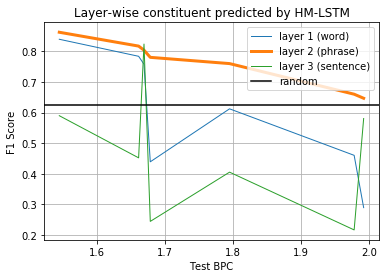

In [9]:
plot_bpc_f1(bpc, f1)

### 2. Phrase-level (layer 1) layer in-depth

In [10]:
def prec_recall_layer1(bpc_score_rst):
    # sort by precision of layer 1
    layer_key = 'layer_1_bound.txt'
    bpc_score_rst = sorted(bpc_score_rst, key=lambda k: k[layer_key][0][0])
    precision = []
    recall = []
    for v in bpc_score_rst:
        precision.append(v[layer_key][0][0])
        recall.append(v[layer_key][1][0])
    return precision, recall

In [11]:
precision, recall = prec_recall_layer1(bpc_score_rst)

In [12]:
def plot_prec_recall(precision, recall):
    plt.plot(precision, recall)
    plt.plot(rand_precision, rand_recall, 'ro', label='random')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc="upper right")
    plt.title('Phrase-level (layer 2) constituent')
    plt.grid(True)
    plt.show()

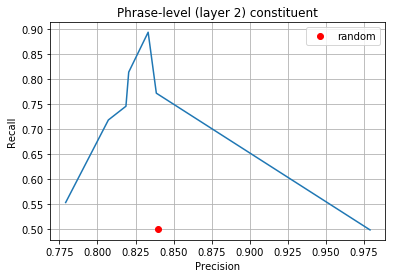

In [13]:
plot_prec_recall(precision, recall)